In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import zipfile

zip_ref = zipfile.ZipFile("/content/gdrive/MyDrive/rice_leaf_diseases.zip", 'r')
zip_ref.extractall("/content/rice_leaf_diseases")
zip_ref.close()

In [3]:
import os

base_dir = '/content/rice_leaf_diseases'

print("Contents of base directory: ")
for rl in os.listdir(base_dir + '/'):
  if os.path.isdir(base_dir + '/' + rl):
    print(rl, "\t: ", len(os.listdir(base_dir + '/' + rl + '/')))

Contents of base directory: 
Brown spot 	:  40
Bacterial leaf blight 	:  40
Leaf smut 	:  40


In [4]:
import tensorflow as tf

# Splitting into train and validation dataset 

batch_size = 16

print("Training")
train_rl = tf.keras.preprocessing.image_dataset_from_directory(base_dir, validation_split=0.2, subset="training", seed=112, batch_size=batch_size)

print("\nValidation")
valid_rl = tf.keras.preprocessing.image_dataset_from_directory(base_dir, validation_split=0.2, subset="validation", seed=112, batch_size=batch_size)


Training
Found 120 files belonging to 3 classes.
Using 96 files for training.

Validation
Found 120 files belonging to 3 classes.
Using 24 files for validation.


In [5]:
# Lookin into the class name
class_names = train_rl.class_names
class_names

['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

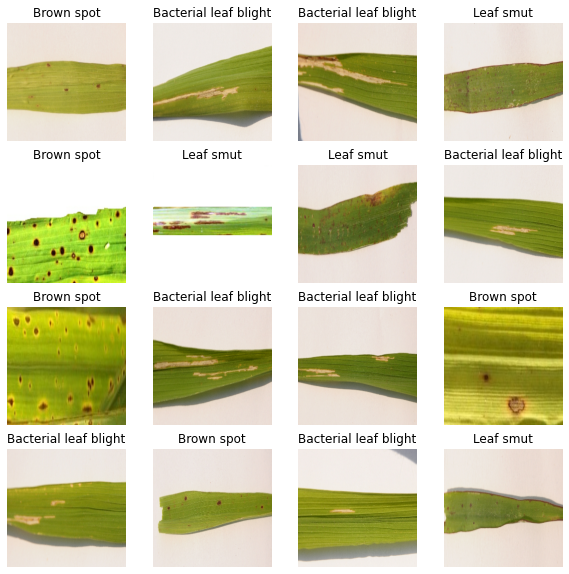

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# img ==> image, lbl ==> label

# Visualization
plt.figure(figsize=(10,10))
for img, lbl in train_rl.take(1): 
  for i in range(16):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(img[i].numpy().astype("uint8"))
    plt.title(class_names[lbl[i]])
    plt.axis('Off')


In [7]:
print("Shape of one training batch")

for img_batch, lbl_batch in train_rl:
  print("inputs : ", img_batch.shape)
  print("labels : ", lbl_batch.shape)
  break

Shape of one training batch
inputs :  (16, 256, 256, 3)
labels :  (16,)


In [8]:
# Prefetch images into memory

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_rl = train_rl.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_rl = valid_rl.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
import keras
from keras import layers

# Preprocessing the dataset
# Normalizing the pixel values - apply to both

normalization_layer = tf.keras.Sequential(
    [
     tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
    ])

train_rl = train_rl.map(lambda x, y: (normalization_layer(x), y))
valid_rl = valid_rl.map(lambda x, y: (normalization_layer(x), y))

In [10]:
import random

# Augmenting images in the train to increase dataset size

data_aug = tf.keras.Sequential(
    [
     tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
     tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
    ])
print("Train size (number of batches) before augmentation : ", len(train_rl))

# Only train_rl
aug_rl = train_rl.map(lambda x, y: (data_aug(x, training=True), y))
print("Size (number of batches) of augmented dataset : ", len(aug_rl))

# Adding to train_rl
train_rl = train_rl.concatenate(aug_rl)
print("Train size (number of batches) after augmentation : ", len(train_rl))

Train size (number of batches) before augmentation :  6
Size (number of batches) of augmented dataset :  6
Train size (number of batches) after augmentation :  12


In [11]:
# Model

model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 3)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(3, activation='softmax')
  ])

model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy'])

model.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)     

In [12]:
history = model.fit(train_rl,
                    validation_data = valid_rl,
                    epochs = 30)

Epoch 1/30
12/12 [==============================] - 5s 146ms/step - loss: 1.5791 - accuracy: 0.4062 - val_loss: 1.2799 - val_accuracy: 0.3333
Epoch 2/30
12/12 [==============================] - 1s 109ms/step - loss: 1.1075 - accuracy: 0.4115 - val_loss: 1.0884 - val_accuracy: 0.5000
Epoch 3/30
12/12 [==============================] - 1s 108ms/step - loss: 0.9698 - accuracy: 0.5729 - val_loss: 1.1698 - val_accuracy: 0.2500
Epoch 4/30
12/12 [==============================] - 1s 112ms/step - loss: 0.9332 - accuracy: 0.5729 - val_loss: 0.8645 - val_accuracy: 0.7083
Epoch 5/30
12/12 [==============================] - 1s 112ms/step - loss: 0.7317 - accuracy: 0.6823 - val_loss: 0.8621 - val_accuracy: 0.6250
Epoch 6/30
12/12 [==============================] - 1s 112ms/step - loss: 0.7177 - accuracy: 0.7083 - val_loss: 0.8233 - val_accuracy: 0.7500
Epoch 7/30
12/12 [==============================] - 1s 108ms/step - loss: 0.6248 - accuracy: 0.7708 - val_loss: 1.1936 - val_accuracy: 0.5000
Epoch 

In [13]:
# Model Accuracy
print("[INFO] Calculating model accuracy")
scores = model.evaluate(valid_rl)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
2/2 [==============================] - 0s 15ms/step - loss: 0.5422 - accuracy: 0.8333
Test Accuracy: 83.33333134651184


Prdicted:  Brown spot
True:  Brown spot
Probability:  0.5564786


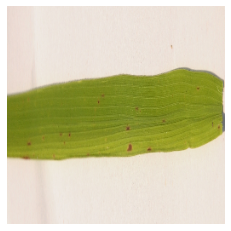

In [15]:
#Prediction
# pick random test data sample from one batch
x = random.randint(9, batch_size - 1)

for i in valid_rl.as_numpy_iterator():
    img, label = i    
    plt.axis('off')   # remove axes
    plt.imshow(img[x])    # shape from (64, 256, 256, 3) --> (256, 256, 3)
    output = model.predict(np.expand_dims(img[x],0))    # getting output; input shape (256, 256, 3) --> (1, 256, 256, 3)
    pred = np.argmax(output[0])    # finding max
    print("Prdicted: ", class_names[pred])    # Picking the label from class_names base don the model output
    print("True: ", class_names[label[x]])
    print("Probability: ", output[0][pred])
    break

In [16]:
scores = model.evaluate(valid_rl)
print(f"Test Accuracy: {scores[1]*100}")

2/2 [==============================] - 0s 16ms/step - loss: 0.5422 - accuracy: 0.8333
Test Accuracy: 83.33333134651184


In [17]:
# Save the model using TensorFlow SavedModel format
model.save('/content/gdrive/MyDrive/Colab Notebooks/rice_leaf_deseases/rice_model.h5')

In [18]:
model.save('/content/gdrive/MyDrive/Colab Notebooks/rice_leaf_deseases/model')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/rice_leaf_deseases/model/assets


In [19]:
mymodel = tf.keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/rice_leaf_deseases/model')

In [20]:
# Conver Model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(mymodel)
converter.experimental_new_converter = True
tflite_model = converter.convert()

open('/content/gdrive/MyDrive/Colab Notebooks/rice_leaf_deseases/rice_model.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpw6b74i8h/assets


52356044